# 준지도 시작

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU, Flatten, LSTM, Conv1D, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import kerastuner as kt
# from gensim.models import Word2Vec
import glob
import ast
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tqdm.pandas()

In [11]:
data_path = './2.라벨링통합/result/kiwi/'
df_nm = glob.glob(f"{data_path}*.csv")[0]
column_name = 'kiwi_token'

df = pd.read_csv(f"{df_nm}", encoding = "utf-8-sig")
df[column_name] = df[column_name].progress_apply(lambda x : ast.literal_eval(x))

df['mark'] = np.random.choice(['train', 'test'], size=len(df), p=[0.8, 0.2])

empty_index = [index for index, sentence in zip(df.index, df[column_name]) if len(sentence) < 1]
df = df.drop(empty_index, axis=0)
df.reset_index(drop=True, inplace=True)
df_pos = df[column_name].copy()
df_pos = pd.DataFrame(df_pos)

data_train = df[df.mark == 'train']
data_test = df[df.mark == 'test']

data_train = data_train.drop(['mark'], axis =1)
data_test = data_test.drop(['mark','target'], axis = 1)

y_train = pd.DataFrame(data_train.target)

X_train = data_train.review
X_train_pos = df_pos[column_name][X_train.index] 

X_test = data_test.review
X_test_pos = df_pos[column_name][X_test.index]

100%|██████████| 12/12 [00:00<00:00, 25103.07it/s]


# Word2Vec 임베딩

In [22]:
df_pos

,kiwi_token
0,"[배송, 걸리, 생각, 빈티지, 느낌, 변형, 스탈링]"
1,"[이너, 착용, 이상, 구매, 미뎜으, 충분하, 레이어드, 쪼끔, 크롭, 무난하, ..."
2,"[너무, 예쁘, 아주, 나오, 감사]"
3,"[긴팔, 원숭이, 길이, 조금, 조금, 원단, 느낌, 제법, 부들, 좋아하, 느낌,..."
4,"[아이폰, 떨틴, 프로멕스, 후면, 전신, 색감, 소재, 좋타, 조금, 루즈, 기장..."
5,"[질감, 배송, 빠르, 바로, 빨간색, 포인트]"
6,"[긴팔, 원숭이, 길이, 조금, 조금, 원단, 느낌, 제법, 부들, 좋아하, 느낌,..."
7,"[아이폰, 떨틴, 프로멕스, 후면, 전신, 색감, 소재, 좋타, 조금, 루즈, 기장..."
8,"[질감, 배송, 빠르, 바로, 빨간색, 포인트]"
9,"[긴팔, 원숭이, 길이, 조금, 조금, 원단, 느낌, 제법, 부들, 좋아하, 느낌,..."


In [16]:
EMBEDDING_DIM = 20
model = Word2Vec(sentences=df[column_name], sg = 1, vector_size=EMBEDDING_DIM, window=5, min_count=1)
w2v_vocab = list(model.wv.index_to_key) # 임베딩 된 단어 리스트
print('Vocabulary size : ',len(w2v_vocab))
print('Vector shape :',model.wv.vectors.shape)

Vocabulary size :  116743
Vector shape : (116743, 20)


In [17]:
w2v_vocab

['가능',
 '사업자',
 '정도',
 '아니',
 '개인',
 '생각',
 '어떻게',
 '경우',
 '판매',
 '지금',
 '많이',
 '현재',
 '등록',
 '너무',
 '질문',
 '스토어',
 '감사',
 '부탁',
 '운영',
 '사업',
 '모르',
 '상품',
 '시작',
 '필요',
 '사람',
 '신고',
 '대출',
 '구매',
 '방법',
 '이상',
 '문제',
 '그냥',
 '진행',
 '관련',
 '매출',
 '시간',
 '혹시',
 '확인',
 '드리',
 '업체',
 '세금',
 '나오',
 '답변',
 '금액',
 '신청',
 '스마트',
 '사용',
 '연락',
 '아직',
 '이번',
 '제품',
 '사장',
 '다시',
 '정보',
 '정말',
 '처음',
 '카드',
 '회사',
 '보험',
 '가요',
 '오늘',
 '없이',
 '이렇게',
 '같이',
 '상황',
 '상태',
 '직접',
 '안녕',
 '부분',
 '계속',
 '네이버',
 '바로',
 '조금',
 '전화',
 '준비',
 '신용',
 '비용',
 '배송',
 '얼마',
 '쇼핑몰',
 '오픈',
 '진짜',
 '그러',
 '내공',
 '그렇',
 '이제',
 '만들',
 '가입',
 '추가',
 '가격',
 '검색',
 '사이트',
 '따로',
 '고객',
 '도움',
 '일반',
 '모두',
 '처리',
 '물건',
 '요즘',
 '이용',
 '말씀',
 '고민',
 '광고',
 '하루',
 '괜찮',
 '번호',
 '알아보',
 '가지',
 '내용',
 '주문',
 '계약',
 '소득',
 '카페',
 '기간',
 '쪽지',
 '추천',
 '온라인',
 '창업',
 '기준',
 '지역',
 '나가',
 '대행',
 '힘들',
 '들어가',
 '다음',
 '관리',
 '예정',
 '일단',
 '직원',
 '택배',
 '사진',
 '먼저',
 '직장',
 '은행',
 '걱정',
 '거래',
 '해당',
 '문의',
 '댓글',
 '부가세',
 

In [18]:
#### 파일 이름 변경!

filename = 'KB_embedding_word2vec20.txt'
model.wv.save_word2vec_format(filename, binary=False)   

In [19]:
# tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_pos)
word_index = tokenizer.word_index
print(tokenizer.index_word)

len(word_index), word_index

{1: '사업자', 2: '가능', 3: '정도', 4: '아니', 5: '개인', 6: '어떻게', 7: '경우', 8: '현재', 9: '등록', 10: '판매', 11: '생각', 12: '많이', 13: '지금', 14: '질문', 15: '스토어', 16: '너무', 17: '부탁', 18: '사업', 19: '상품', 20: '신고', 21: '감사', 22: '운영', 23: '시작', 24: '구매', 25: '모르', 26: '방법', 27: '필요', 28: '사람', 29: '대출', 30: '문제', 31: '관련', 32: '이상', 33: '진행', 34: '혹시', 35: '매출', 36: '시간', 37: '드리', 38: '확인', 39: '세금', 40: '그냥', 41: '업체', 42: '답변', 43: '금액', 44: '신청', 45: '스마트', 46: '나오', 47: '가요', 48: '사용', 49: '연락', 50: '이번', 51: '제품', 52: '아직', 53: '처음', 54: '회사', 55: '보험', 56: '정보', 57: '카드', 58: '다시', 59: '사장', 60: '이렇게', 61: '같이', 62: '정말', 63: '안녕', 64: '없이', 65: '네이버', 66: '상황', 67: '상태', 68: '오늘', 69: '부분', 70: '직접', 71: '신용', 72: '준비', 73: '쇼핑몰', 74: '내공', 75: '배송', 76: '계속', 77: '바로', 78: '오픈', 79: '가입', 80: '비용', 81: '고객', 82: '만들', 83: '검색', 84: '사이트', 85: '추가', 86: '얼마', 87: '도움', 88: '그렇', 89: '전화', 90: '물건', 91: '조금', 92: '이제', 93: '따로', 94: '가격', 95: '진짜', 96: '일반', 97: '모두', 98: '처리', 99: '이용', 100: '가지',

(27681,
 {'사업자': 1,
  '가능': 2,
  '정도': 3,
  '아니': 4,
  '개인': 5,
  '어떻게': 6,
  '경우': 7,
  '현재': 8,
  '등록': 9,
  '판매': 10,
  '생각': 11,
  '많이': 12,
  '지금': 13,
  '질문': 14,
  '스토어': 15,
  '너무': 16,
  '부탁': 17,
  '사업': 18,
  '상품': 19,
  '신고': 20,
  '감사': 21,
  '운영': 22,
  '시작': 23,
  '구매': 24,
  '모르': 25,
  '방법': 26,
  '필요': 27,
  '사람': 28,
  '대출': 29,
  '문제': 30,
  '관련': 31,
  '이상': 32,
  '진행': 33,
  '혹시': 34,
  '매출': 35,
  '시간': 36,
  '드리': 37,
  '확인': 38,
  '세금': 39,
  '그냥': 40,
  '업체': 41,
  '답변': 42,
  '금액': 43,
  '신청': 44,
  '스마트': 45,
  '나오': 46,
  '가요': 47,
  '사용': 48,
  '연락': 49,
  '이번': 50,
  '제품': 51,
  '아직': 52,
  '처음': 53,
  '회사': 54,
  '보험': 55,
  '정보': 56,
  '카드': 57,
  '다시': 58,
  '사장': 59,
  '이렇게': 60,
  '같이': 61,
  '정말': 62,
  '안녕': 63,
  '없이': 64,
  '네이버': 65,
  '상황': 66,
  '상태': 67,
  '오늘': 68,
  '부분': 69,
  '직접': 70,
  '신용': 71,
  '준비': 72,
  '쇼핑몰': 73,
  '내공': 74,
  '배송': 75,
  '계속': 76,
  '바로': 77,
  '오픈': 78,
  '가입': 79,
  '비용': 80,
  '고객': 81,
  '만들': 82,
  '검색': 83

In [20]:
def check_frequency(num, tokenizer) :
    threshold = num # 등장 빈도가 threshold보다 낮으면 희귀 단어로 분류
    total_cnt = len(tokenizer.word_index) # tokenizing된 모든 단어의 개수
    rare_cnt = 0 # 희귀 단어 개수
    total_freq = 0 # 입력 데이터의 전체 단어 빈도
    rare_freq = 0 # 희귀 단어 등장 빈도 합
    
    for word, freq in tokenizer.word_counts.items():
        total_freq += freq # 전체 빈도
        
        if freq  < threshold : # 전체 등장 빈도가 threshold보다 낮으면
            rare_cnt += 1 # 희귀 단어로 간주
            rare_freq += freq # 희귀 단어 등장 빈도 업데이트
            
    print(f'최소 등장 빈도 : {threshold-1}')
    print(f'단어 집합(vocabulary) 크기 : {total_cnt}')
    print(f'희귀 단어 수 : {rare_cnt}')
    print(f'단어 집합에서 희귀 단어의 비율 : {(rare_cnt/total_cnt)*100}')
    print(f'전체 단어 빈도에서 희귀 단어 비율 : {(rare_freq/total_freq)*100}')
    
    return total_cnt, rare_cnt

In [21]:
for THRESHOLD in range(1, 15) :
    check_frequency(THRESHOLD, tokenizer)
    print('='*70)

최소 등장 빈도 : 0
단어 집합(vocabulary) 크기 : 27681
희귀 단어 수 : 0
단어 집합에서 희귀 단어의 비율 : 0.0
전체 단어 빈도에서 희귀 단어 비율 : 0.0
최소 등장 빈도 : 1
단어 집합(vocabulary) 크기 : 27681
희귀 단어 수 : 12894
단어 집합에서 희귀 단어의 비율 : 46.580687113904844
전체 단어 빈도에서 희귀 단어 비율 : 3.0442902440579203
최소 등장 빈도 : 2
단어 집합(vocabulary) 크기 : 27681
희귀 단어 수 : 17036
단어 집합에서 희귀 단어의 비율 : 61.5440193634623
전체 단어 빈도에서 희귀 단어 비율 : 5.0001534658491265
최소 등장 빈도 : 3
단어 집합(vocabulary) 크기 : 27681
희귀 단어 수 : 19137
단어 집합에서 희귀 단어의 비율 : 69.13406307575593
전체 단어 빈도에서 희귀 단어 비율 : 6.488299999763898
최소 등장 빈도 : 4
단어 집합(vocabulary) 크기 : 27681
희귀 단어 수 : 20376
단어 집합에서 희귀 단어의 비율 : 73.61005744012138
전체 단어 빈도에서 희귀 단어 비율 : 7.658418074027204
최소 등장 빈도 : 5
단어 집합(vocabulary) 크기 : 27681
희귀 단어 수 : 21253
단어 집합에서 희귀 단어의 비율 : 76.77829558180701
전체 단어 빈도에서 희귀 단어 비율 : 8.693722302365499
최소 등장 빈도 : 6
단어 집합(vocabulary) 크기 : 27681
희귀 단어 수 : 21938
단어 집합에서 희귀 단어의 비율 : 79.25291716339727
전체 단어 빈도에서 희귀 단어 비율 : 9.66409867145795
최소 등장 빈도 : 7
단어 집합(vocabulary) 크기 : 27681
희귀 단어 수 : 22472
단어 집합에서 희귀 단어의 비율 : 8

In [22]:
# vocab size

threshold = 1
total_cnt, rare_cnt = check_frequency(threshold, tokenizer)
vocab_size = total_cnt - rare_cnt + 1
print(vocab_size)

최소 등장 빈도 : 0
단어 집합(vocabulary) 크기 : 27681
희귀 단어 수 : 0
단어 집합에서 희귀 단어의 비율 : 0.0
전체 단어 빈도에서 희귀 단어 비율 : 0.0
27682


In [23]:
# token화
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') # 자주나오는 상위 vocab_size만 학습, 학습되지 않은 단어는 1로 처리
tokenizer.fit_on_texts(X_train_pos)
word_index = tokenizer.word_index
print(len(word_index))

27682


In [24]:
# 다시 문장들을 정수 토큰화
# OOV 설정했기 때문에 VOCAB_SIZE 초과하는 단어들은 OOV 1 정수로 인코딩 처리됩니다.
X_train_pad = tokenizer.texts_to_sequences(X_train_pos) 
X_test_pad = tokenizer.texts_to_sequences(X_test_pos)

In [25]:
# pos tagging 된거 길이 = 토큰화 된거 길이 는 같아야합니다
print(len(X_train_pos), len(X_train_pad))
print(len(X_test_pos), len(X_test_pad))

9947 9947
495440 495440


In [26]:
# 패딩 해준건 행렬 형태라서 index가 없습니다
# 준지도 파트에서 index의 이동을 추적할 용도로 별도의 index 데이터를 형성해줍니다
X_train_pad_index = X_train_pos.index
X_test_pad_index = X_test_pos.index

X_train_pad_index, X_test_pad_index

(Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
        ...
        9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946],
       dtype='int64', length=9947),
 Index([  9947,   9948,   9949,   9950,   9951,   9952,   9953,   9954,   9955,
          9956,
        ...
        505377, 505378, 505379, 505380, 505381, 505382, 505383, 505384, 505385,
        505386],
       dtype='int64', length=495440))

# Padding

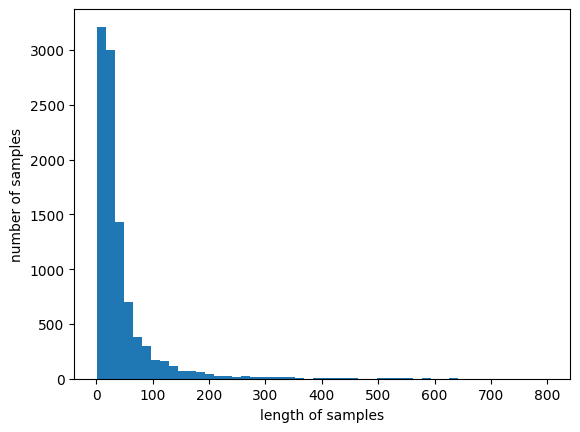

문장의 최대 길이 : 801
문장의 평균 길이 : 42.58037599276164


In [27]:
plt.hist([len(sent) for sent in X_train_pad], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('문장의 최대 길이 :', max(len(l) for l in X_train_pad))
print('문장의 평균 길이 :', sum(map(len, X_train_pad))/len(X_train_pad))

In [28]:
 def below_len(max_len, sentences) :
    cnt = 0
    for sent in sentences :
        if len(sent) <= max_len :
            cnt += 1
    print(f'전체 문장 중 길이가 {max_len} 이하인 샘플의 비율: {(cnt/len(sentences))*100}')
          
for MAX in range(0, 802, 10) :  ## 위에서 문장 최대 길이 확인해서 변경  ## 차미 >> 802로 수정
    below_len(MAX, X_train_pad)

전체 문장 중 길이가 0 이하인 샘플의 비율: 0.0
전체 문장 중 길이가 10 이하인 샘플의 비율: 15.914346033980095
전체 문장 중 길이가 20 이하인 샘플의 비율: 41.80154820548909
전체 문장 중 길이가 30 이하인 샘플의 비율: 59.796923695586614
전체 문장 중 길이가 40 이하인 샘플의 비율: 71.2878254750176
전체 문장 중 길이가 50 이하인 샘플의 비율: 77.83251231527095
전체 문장 중 길이가 60 이하인 샘플의 비율: 82.56760832411783
전체 문장 중 길이가 70 이하인 샘플의 비율: 85.46295365436816
전체 문장 중 길이가 80 이하인 샘플의 비율: 87.78526188800643
전체 문장 중 길이가 90 이하인 샘플의 비율: 89.85623806172715
전체 문장 중 길이가 100 이하인 샘플의 비율: 91.36423042123253
전체 문장 중 길이가 110 이하인 샘플의 비율: 92.40977179048959
전체 문장 중 길이가 120 이하인 샘플의 비율: 93.33467377098623
전체 문장 중 길이가 130 이하인 샘플의 비율: 94.36010857544989
전체 문장 중 길이가 140 이하인 샘플의 비율: 95.12415803759927
전체 문장 중 길이가 150 이하인 샘플의 비율: 95.54639589826078
전체 문장 중 길이가 160 이하인 샘플의 비율: 96.0189001709058
전체 문장 중 길이가 170 이하인 샘플의 비율: 96.51151100834421
전체 문장 중 길이가 180 이하인 샘플의 비율: 96.87342917462551
전체 문장 중 길이가 190 이하인 샘플의 비율: 97.28561375289033
전체 문장 중 길이가 200 이하인 샘플의 비율: 97.5972655071881
전체 문장 중 길이가 210 이하인 샘플의 비율: 97.79833115512214
전체 문장 중 길이가 22

In [29]:
max_len = 230  ######### 98 % 로 max_len 입력   ## 차미 >> 230으로 수정

X_train_pad = pad_sequences(X_train_pad, maxlen = max_len)
X_test_pad = pad_sequences(X_test_pad, maxlen = max_len)

In [30]:
# check data
print(X_train_pad.shape)
print(y_train.shape)
print(X_test_pad.shape)

(9947, 230)
(9947, 1)
(495440, 230)


# Word2Vec 파일 불러오기

In [31]:
import os

In [32]:
embedding_dict = {}

f = open(os.path.join('', 'KB_embedding_word2vec20.txt'), encoding = 'utf-8')
for line in f :
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedding_dict[word] = coefs
f.close()

embedding_dict

{'116743': array(['20'], dtype='<U2'),
 '가능': array(['0.6199746', '-0.041593146', '-0.83111537', '-0.33194873',
        '-0.7957379', '-1.1515528', '-0.22190826', '0.4497648',
        '-0.724413', '0.26633966', '0.41362327', '-0.34448057',
        '-0.10727598', '-1.3406966', '-0.018671077', '0.17366499',
        '0.71418196', '0.8267092', '-1.1421381', '-0.51326793'],
       dtype='<U12'),
 '사업자': array(['0.11980323', '-0.5455971', '0.46031642', '-0.4642585',
        '-1.1389322', '-0.96615934', '0.5976654', '0.19757788',
        '-0.17096937', '0.030651122', '0.9453347', '0.27763754',
        '0.38409477', '-0.9039229', '0.8812043', '0.6396162',
        '-0.38682547', '-0.0521202', '-0.89214176', '-1.3798931'],
       dtype='<U11'),
 '정도': array(['0.17837082', '0.78061044', '-0.26394522', '0.6954532',
        '-0.36757836', '-0.44725165', '0.5828785', '0.80691427',
        '-0.17748705', '0.45384157', '0.57835174', '-0.09139944',
        '0.6438869', '-0.42816678', '0.20288004', '-0.

In [33]:
# embedding matrix
embedding_vocab = len(tokenizer.index_word) + 1
embedding_dim = 20

embedding_matrix = np.zeros((embedding_vocab, embedding_dim))

def get_vector(word):
    if word in model.wv :   ## 은지> model.wv로 수정
        return model.wv[word]  ## 은지> model.wv로 수정
    else :
        return None
    
for word, idx in tokenizer.word_index.items() : #훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내옴
    temp = get_vector(word) # 단어(key)에 해당되는 임베딩 벡터의 100개의 값을 임시 변수에 저장
    if temp is not None : # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[idx] = temp # 해당 단어 위치의 행에 벡터의 값을 저장

In [34]:
print(np.shape(embedding_matrix))
print(embedding_matrix)

(27683, 20)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.11980323 -0.54559708  0.46031642 ... -0.0521202  -0.89214176
  -1.37989306]
 ...
 [ 1.68466711  0.09047018 -0.60284936 ... -0.2928004  -0.99758506
  -1.19911146]
 [ 0.46045625  0.30557778  1.12053204 ... -0.39689082 -1.34008586
  -0.66143274]
 [ 0.21502048 -0.11959953  0.08956432 ... -0.01919334 -1.58530676
  -0.00176417]]


# Model 1 (LSTM)

In [35]:
vocab_size

27682

In [36]:
embedding_dim

20

In [37]:
max_len

230

In [38]:
len(embedding_matrix)

27683

In [39]:
# tuner version
# 밑에 설정된 step의 크기, 노드 학습rate dropout rate 의 min,max범위 등은 직접 변경하셔도 됩니다
def build_lstm(hp):
    model = Sequential()
    model.add(Embedding(embedding_vocab, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(units=hp.Int('units1', min_value=4, max_value=128,step=16)))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256,step=32), activation='relu'))
    model.add(Dropout(rate = hp.Float('drop_out_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss = 'binary_crossentropy',
                  metrics=['acc'])
    return model

In [40]:
print(os.getcwd())

c:\Users\tinac\OneDrive - 한양대학교\2023\KB\[4] DCX\4. 준지도


In [41]:
tuner = kt.RandomSearch(
    build_lstm,
    objective='val_acc',
    max_trials = 15,  #  total number of trials 총 15번 랜덤서치를 합니다
    executions_per_trial=2, # the number of models that should be built and fit for each trial
    project_name ='c:/Users/tinac/lstm_KB_try_01') # 현재 주피터파일이 있는 위치에 lstm1이라는 폴더가 생성됩니다. 

# ***모델 다시 돌릴때 주의사항
# 모델을 다시 돌릴땐 project_name을 바꾸던지 현재 위치(폴더)를 바꿔야 돌아갑니다
# 아니면 이전에 만들어진 파일을 삭제하고 다시 돌리면 됩니다
# 폴더 안에는 test해본 모델들의 정보가 기록됩니다

In [42]:
tuner.search_space_summary() # 랜덤서치의 범위를 요약해서 보여줍니다

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
drop_out_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [43]:
# 모델 input으로 정수인코딩 된 train 데이터와 라벨이 들어갑니다
# epoch, validation_split, patience 등 하이퍼파라미터들을 원하시는대로 조정합니다 

tuner.search(X_train_pad, y_train, epochs=15, validation_split=0.25, 
             callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3)]) 

Trial 15 Complete [00h 04m 28s]
val_acc: 0.8218737244606018

Best val_acc So Far: 0.8423803746700287
Total elapsed time: 01h 25m 02s


In [44]:
tuner.results_summary() 

# Score는 val_acc 를 의미합니다
# 탑 10개 모델의 정보를 출력해줍니다

Results summary
Results in c:/Users/tinac/lstm_KB_try_01
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 02 summary
Hyperparameters:
units1: 20
units2: 128
drop_out_rate: 0.1
learning_rate: 0.00713752975485827
Score: 0.8423803746700287

Trial 13 summary
Hyperparameters:
units1: 20
units2: 256
drop_out_rate: 0.2
learning_rate: 0.0033934342058122256
Score: 0.837756335735321

Trial 12 summary
Hyperparameters:
units1: 100
units2: 64
drop_out_rate: 0.1
learning_rate: 0.00042114006631874593
Score: 0.8313228785991669

Trial 11 summary
Hyperparameters:
units1: 36
units2: 128
drop_out_rate: 0.2
learning_rate: 0.0019812115972674994
Score: 0.8305186927318573

Trial 01 summary
Hyperparameters:
units1: 100
units2: 128
drop_out_rate: 0.5
learning_rate: 0.001536166799289992
Score: 0.8299155533313751

Trial 10 summary
Hyperparameters:
units1: 84
units2: 192
drop_out_rate: 0.1
learning_rate: 0.0002750224505177828
Score: 0.8242863118648529

Trial 06 summary
Hyperparameters:
unit

In [45]:
# 가장 성능이 좋았던 모델을 저장해줍니다 
lstm_best_model = tuner.get_best_models(num_models=1)[0]

# Model 2 (CNN)

In [46]:
def build_cnn(hp):
    model = Sequential()
    model.add(Embedding(embedding_vocab, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
    model.add(Dropout(rate = hp.Float('drop_out_rate1', 0.1, 0.5, step=0.1)))
    
    filters_ = hp.Int('filters', 16, 128, step=32)
    kernel_size_ = hp.Choice('kernerl_size',values=[2,3,4,5])
    model.add(Conv1D(filters = filters_, kernel_size = kernel_size_,
                     strides = 1,padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=hp.Int('units', min_value=16, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate = hp.Float('drop_out_rate2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss = 'binary_crossentropy',
                  metrics=['acc'])
    return model

In [47]:
tuner = RandomSearch(
    build_cnn,
    objective='val_acc',
    max_trials = 15,  #  total number of trials
    executions_per_trial=2, # the number of models that should be built and fit for each trial
    project_name ='c:/Users/tinac/cnn_KB_try_01')

In [48]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
drop_out_rate1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
kernerl_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
drop_out_rate2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [51]:
tuner.search(X_train_pad,y_train, epochs=15, validation_split=0.25, 
             callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3)]) 

In [52]:
tuner.results_summary()

Results summary
Results in c:/Users/tinac/cnn_KB_try_01
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 01 summary
Hyperparameters:
drop_out_rate1: 0.30000000000000004
filters: 80
kernerl_size: 5
units: 144
drop_out_rate2: 0.30000000000000004
learning_rate: 0.003039763625882944
Score: 0.8184559643268585

Trial 07 summary
Hyperparameters:
drop_out_rate1: 0.2
filters: 80
kernerl_size: 2
units: 112
drop_out_rate2: 0.2
learning_rate: 0.011048740852797497
Score: 0.8170486390590668

Trial 10 summary
Hyperparameters:
drop_out_rate1: 0.4
filters: 16
kernerl_size: 2
units: 176
drop_out_rate2: 0.5
learning_rate: 0.017936807293840906
Score: 0.8104141354560852

Trial 06 summary
Hyperparameters:
drop_out_rate1: 0.5
filters: 16
kernerl_size: 2
units: 240
drop_out_rate2: 0.30000000000000004
learning_rate: 0.026928042220298303
Score: 0.8069963753223419

Trial 13 summary
Hyperparameters:
drop_out_rate1: 0.1
filters: 16
kernerl_size: 2
units: 16
drop_out_rate2: 0.1
learning_rate

In [53]:
cnn_best_model = tuner.get_best_models(num_models=1)[0]

# Model 1, 2 합의

In [54]:
# 확률을 이산변수로
def to_binary(result):
    for i in range(len(result)):
        if result[i]>= 0.5: # threshold 조정이 필요하다면 여기서 조정하면 됩니다
            result[i] = 1
        else:
            result[i] = 0
    return result

# 합의 여부를 출력
def agreement(df):
    x = df[0]
    y = df[1]
    if x == y:
        return True
    else:
        return False

In [55]:
model1_result = lstm_best_model.predict(X_test_pad) # model1 결과
model1_result = to_binary(model1_result) # 임계값을 기준으로 0,1로 변환

model2_result = cnn_best_model.predict(X_test_pad) # model2 결과
model2_result = to_binary(model2_result) # 임계값을 기준으로 0,1로 변환


#model1, model2 결과를 한 dataframe에 저장
result1 = pd.DataFrame(model1_result, columns=['model1']) 
result1['model2'] = model2_result
result1.index = X_test_pad_index

# aggrement 함수로 합의 여부 출력
result1['accepted'] = result1.apply(agreement,axis=1) # 합의 여부 출력
result1

15483/15483 [==============================] - 41s 3ms/step


C:\Users\tinac\AppData\Local\Temp\ipykernel_30412\1954673025.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = df[0]
C:\Users\tinac\AppData\Local\Temp\ipykernel_30412\1954673025.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = df[1]


,model1,model2,accepted
9947,0.0,1.0,False
9948,0.0,1.0,False
9949,0.0,0.0,True
9950,0.0,1.0,False
9951,0.0,0.0,True
...,...,...,...
505382,0.0,0.0,True
505383,0.0,0.0,True
505384,0.0,0.0,True
505385,0.0,0.0,True


In [56]:
result1['accepted'].value_counts() # True는 합의된 개수를 의미합니다

accepted
True     413307
False     82133
Name: count, dtype: int64

In [57]:
success = result1[result1['accepted']==True].index  # 합의된 행의 인덱스
fail = result1[result1['accepted']==False].index

In [58]:
print('Model3에 Train으로 편입될 합의된 인덱스\n',len(success))
print('Model3에 Test로 편입될 합의되지 않은 인덱스\n',len(fail))

Model3에 Train으로 편입될 합의된 인덱스
 413307
Model3에 Test로 편입될 합의되지 않은 인덱스
 82133


In [59]:
y_agree = result1['model1'][success] # 새로운 y 데이터를 만듭니다
y_agree.value_counts(), y_agree

(model1
 0.0    306949
 1.0    106358
 Name: count, dtype: int64,
 9949      0.0
 9951      0.0
 9952      0.0
 9953      0.0
 9955      0.0
          ... 
 505382    0.0
 505383    0.0
 505384    0.0
 505385    0.0
 505386    0.0
 Name: model1, Length: 413307, dtype: float32)

In [ ]:
# # model 3에 input으로 넣을 새로운 x,y data들을 만드는 단계입니다
# X_agree_pad = np.empty((1,max_len), int) # 데이터 크기에 맞게 가짜 행렬을 만들어줍니다
# X_agree_pad
# for sentence, index in zip(X_test_pad, X_test_pad_index):
#     if index in success: # test 데이터 중 합의된 경우
#         X_agree_pad = np.vstack([X_agree_pad,sentence]) # 밑에 결합시켜줍니다
# X_agree_pad = np.delete(X_agree_pad,0,0) # 맨 첫번째 행은 데이터를 합치기 위한 가짜 행이기 때문에 삭제합니다
    
# # 같은 원리로 합의되지 않았던 데이터들을 합쳐줍니다
# X_fail_pad = np.empty((1,max_len), int)
# X_fail_pad
# for sentence, index in zip(X_test_pad, X_test_pad_index):
#     if index in fail:
#         X_fail_pad = np.vstack([X_fail_pad,sentence])
# X_fail_pad = np.delete(X_fail_pad,0,0)

In [74]:
# 합의된 데이터 처리
X_agree_pad = np.array([sentence for sentence, index in zip(X_test_pad, X_test_pad_index) if index in success])

# 합의되지 않은 데이터 처리
X_fail_pad = np.array([sentence for sentence, index in zip(X_test_pad, X_test_pad_index) if index in fail])


In [75]:
# train + test중 성공한것
X_new_train_index = list(X_train_pad_index) +list(success)
print(len(X_new_train_index ))

# 나머지 test set
print(len(fail))

423254
82133


In [76]:
# 기존의 train set에 합의된 데이터를 합칩니다
X_new_train_pad = np.vstack((X_train_pad, X_agree_pad))

# 새로운 train set의 y 데이터를 만듭니다
y_agree_df = pd.DataFrame(y_agree.values,index=y_agree.index, columns=['target'])
y_new_train = pd.concat([y_train,y_agree_df])

# Model 3 (GRU)

In [77]:
def build_gru(hp):
    model = Sequential()
    model.add(Embedding(embedding_vocab, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
    model.add(GRU(units=hp.Int('units1', min_value=4, max_value=128,step=16)))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256,step=32), activation='relu'))
    model.add(Dropout(rate = hp.Float('drop_out_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss = 'binary_crossentropy',
                  metrics=['acc'])
    return model

In [78]:
tuner = RandomSearch(
    build_gru,
    objective='val_acc',
    max_trials = 10,  #  total number of trials
    executions_per_trial=1, # the number of models that should be built and fit for each trial
    project_name ='c:/Users/tinac/gru_KB_try_01')

In [79]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
drop_out_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [80]:
tuner.search(X_new_train_pad,np.array(y_new_train), epochs=10, validation_split=0.25, 
             callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3)])

Trial 10 Complete [00h 43m 05s]
val_acc: 0.991919755935669

Best val_acc So Far: 0.9962764978408813
Total elapsed time: 11h 43m 53s


In [81]:
tuner.results_summary()

Results summary
Results in c:/Users/tinac/gru_KB_try_01
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 01 summary
Hyperparameters:
units1: 68
units2: 64
drop_out_rate: 0.5
learning_rate: 0.0003601003921309133
Score: 0.9962764978408813

Trial 00 summary
Hyperparameters:
units1: 36
units2: 192
drop_out_rate: 0.5
learning_rate: 0.0001895853508666445
Score: 0.9958890080451965

Trial 02 summary
Hyperparameters:
units1: 84
units2: 32
drop_out_rate: 0.1
learning_rate: 0.00012544547330964388
Score: 0.995879590511322

Trial 05 summary
Hyperparameters:
units1: 100
units2: 256
drop_out_rate: 0.2
learning_rate: 0.0014307666528640438
Score: 0.9957661628723145

Trial 07 summary
Hyperparameters:
units1: 36
units2: 64
drop_out_rate: 0.4
learning_rate: 0.00018196615119335302
Score: 0.9956244230270386

Trial 06 summary
Hyperparameters:
units1: 100
units2: 160
drop_out_rate: 0.2
learning_rate: 0.0010570471276936681
Score: 0.9954259395599365

Trial 09 summary
Hyperparameters:
uni

In [82]:
gru_best_model = tuner.get_best_models(num_models=1)[0]

In [83]:
#합의 안된 데이터들 최종 예측
result2 = gru_best_model.predict(X_fail_pad)
result2 = to_binary(result2)

2567/2567 [==============================] - 36s 14ms/step


In [84]:
y_final_result = pd.DataFrame(result2, index=fail,columns=['target'])
print(y_final_result['target'].value_counts())

y_total = pd.concat([y_new_train,y_final_result])

target
0.0    60661
1.0    21472
Name: count, dtype: int64


In [85]:
# 전체 data의 x값
X_total_pad = np.vstack((X_new_train_pad, X_fail_pad))

In [86]:
# 전체 data의 원문
X_total = pd.concat([X_train,X_test])

In [87]:
# y_total의 index에 맞춰서 원문을 조정해줍니다
reset_indexes = y_total.index

In [88]:
#dff로 최종 마무리
df = df.drop(['mark'], axis = 1)
#df = df0.drop(drop_train_index) # 위에서 빈 셈플 제거했던 있으면 제거
df = df.reindex(reset_indexes) # y total의 인덱스에 따라 조정
sum(df.index == y_total.index) 

505387

In [89]:
df['target'] = y_total

In [90]:
df

,review,target,Mecab_token
0,웹디자이너 열정페이 놀랍지도 않은 차 웹디자이너 삼십 대엔 뭐라도 될 줄 알았지 슝...,0.0,"[데코, 백수, 이야기, 감축, 나이, 직업, 수많, 감사, 사회생활, 별로, 가수..."
1,국가 관점의 혁신 성장 Vision 수립이 필요 예전에는 과 중국간 기술 격차가 ...,0.0,"[인터넷, 이야기, 경각심, 도제, 구조, 진화, 재료, 신속, 실업, 계획, 도입..."
2,시작도 하기 전에 녹아버렸네 의심 없는 겨울이었다 같은 나라인데도 기차는 마법같이 ...,0.0,"[살살, 계좌, 행복, 아래쪽, 미지수, 심야, 아침, 감사, 근처, 지불, 컴퓨터..."
3,제주도 길이 보인다 서귀포에 이어도의 길이 있다서귀포 혁신도시에서 중문관광단지까지이...,0.0,"[국립, 학기, 규정, 구조, 자켓, 계획, 제거, 조석, 바람, 제작, 장비, 설..."
4,SNS사업자의 O O전략 잘못된 정의들이 난무한다 Online에서 Offline으로...,0.0,"[창발, 하루, 고객, 지불, 계획, 도입, 광고, 취하, 데이터, 협의, 제작, ..."
...,...,...,...
505301,내공 빈티지 제품 가품이면 환불 가능한가요 안녕하세요 대 직장인입니다 빈티지샵에서 ...,0.0,"[이야기, 환불, 발매, 요청, 구매, 내공, 분명, 직장인, 신고, 제품, 가요,..."
505304,인터넷 빈티지 쇼핑몰 괜찮나요 인터넷 빈티지 쇼핑몰에서 처음으로 옷을 구매해보려고 ...,1.0,"[인터넷, 처음, 가격, 쇼핑몰, 사이트, 공수, 의심, 구매, 상태, 그러, 빈티..."
505311,빈티지 샵 제품 교환 가능하다고 할까요 인스타 빈티지 샵인데 반품 가능하다고 적혀있...,0.0,"[가격, 부담, 교환, 자신, 배송, 빈티지, 스타, 똑같, 반품, 제품, 가능]"
505336,내공 인스타 빈티지 샵에서 옷을 구매했는데 판매자와 연락이 안돼요 인스타 빈티지 샵...,0.0,"[일전, 하루, 구매, 내공, 판매자, 디엠, 올라오, 가요, 저번, 입금, 모르,..."


In [91]:
df.target.value_counts()

target
0.0    373843
1.0    131544
Name: count, dtype: int64

In [92]:
# informative인 데이터 
X_informative = df[df['target']==1]  
X_informative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131544 entries, 6 to 505304
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review       131544 non-null  object 
 1   target       131544 non-null  float64
 2   Mecab_token  131544 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.0+ MB


In [93]:
X_informative['target'].value_counts()

target
1.0    131544
Name: count, dtype: int64

In [94]:
X_informative[['review','target']].sample(20)

,review,target
109307,[투비즈온] 도매 위탁 배송 가능 & 셀러 모집 -------------------...,1.0
176481,사업자내고 광고전화오는데 어디서 정보가 나간걸까요 사업자 내고 스토어팜 등록했는데요...,1.0
230094,유튜브 면세사업자 영세율세금계산서 안녕하세요 유튜브면세사업자입니다 ^^ 내년에 면세...,1.0
129264,일반 스마트스토어에 해외구매대행 상품 업로드는 안되는건가요? 초보셀러입니다. 국내 ...,1.0
172990,사업자 통장 발급이 하는게 나은가요 현재 스토어팜과 에이블리에 팔 예정인데 개인통장...,1.0
460296,간이과세자 포기 신고 신규 사업자 등록을 하면서 간이과세자로 등록되었다가 현재 간이...,1.0
154306,스마트스토어 진단 평가좀 이번에 상품을 추가하여 촬영 상세페이지에 재투자를 했는데 ...,1.0
296585,어제 세무서가거 사업자등록 신청하고 왔습니다 일에 결과나온다고 하네요 궁금한게 있는...,1.0
206581,네이버스마트스토어 지속적인 오류피해 단체로 항의해보죠 개인이 항의해봐야 보상은 또 ...,1.0
298715,한 주소지 개의 사업자 등록 안녕하세요 기존에 집을 사업장으로 해서 사업을 하고 있...,1.0


In [95]:
# informative 문장 저장
X_informative.to_csv('[KB]informative_차미.csv', encoding='utf-8-sig')

In [96]:
X_uninformative = df[df['target']==0]  
X_uninformative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373843 entries, 0 to 505376
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review       373843 non-null  object 
 1   target       373843 non-null  float64
 2   Mecab_token  373843 non-null  object 
dtypes: float64(1), object(2)
memory usage: 11.4+ MB


In [97]:
X_uninformative['target'].value_counts()

target
0.0    373843
Name: count, dtype: int64

In [98]:
X_uninformative[['review','target']].sample(20)

,review,target
332248,내공 새한 컴퍼니 알바 알바천국에 이력서 올렸는데 새한컴퍼니라는 컨설팅 회사에서 연...,0.0
23142,딸키우는 사장님 질문좀 맘카페 가입이안되서 여기질문을ㅎㅎ 어제 딸래미랑 롤러장갔는데...,0.0
48367,제주도 한치낚시 제주도 한치낚시는 항상 재밌습니다. 이제 올해는 아웃 이네요~ 내년...,0.0
163984,유아용품 위탁판매 하실 벤더분 찾습니다 종합몰 오픈마켓 오프라인 매장 등 유아용품 ...,0.0
406994,중기청 중소기업청년전세자금대출 문의 예시 전세 억 대출가능시 처음 계약금 영수증 발...,0.0
294069,신한카드 더클래식 안녕하세요 남편 신한카드 더클래식 pp카드 발급을 하고 싶습니다^...,0.0
341356,네이버지도 체인점해지하고 다른 업종으로 장사해서 정보 변경 할랬더니 관리자가 본사로...,0.0
430731,사업자등록 후 회사에 취직하는 경우 대 보험 사업자 등록 먼저 하고 간이과세자로 있...,0.0
466477,내공 중기청 전세자금대출 프로 내공 제가 월 일부터 일했구 회사에선 월 일날 월 일...,0.0
1590,스스 있는 직장인 입니다 잘부탁드려요 반갑습니다,0.0


In [99]:
X_uninformative.to_csv('[KB]uninfo_차미.csv', encoding='utf-8-sig')